# Solución parte 1

## CNN para la clasificación de especies de tipos de cartas de Naipe como tarea de entretenimiento

Se presenta una arquitectura de red neuronal híbrida, que cuenta con capas de red convolucionales desde la entrada hasta cierta capa oculta y se conectan con capas Fully Connected en las últimas capas ocultas, junto con la capa de salida para realizar una clasificación de diferentes tipos de cartas de Naipe.

La presente aplicación tiene un sentido netamente de entretenimiento. Pero se consideró una oportunidad divertida para solucionar este caso de clasificación.

#### Cargue de librerías

In [13]:
import torch
import numpy as np 
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

#### Lectura de GPU

In [14]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    print('CUDA disponible. Entrenamiento en GPU.')
else:
    print('CUDA no disponible. Entrenamiento en CPU.')

CUDA no disponible. Entrenamiento en CPU.


#### Definicón del directorio de las imágenes a utilizar y cargue de las misma

En esta sección se realiza la configuración para realizar DataAugmentatios al set de datos elegido. Como transformaciones a aplicar, se eligieron: Dar la vuelta a la foto de forma aleatoria horizontalmente (RandomHorizontalFlip), hacer una rotación de 20° aleatoriamente (transforms.RandomRotation(20)), se realizó una normalización con algunos valores por defecto para expereminetos de media, desviación estandar de 0.5 y 0.5 respectivamente, para cada una de las capas RGB de las imágenes. En el mismo sentido, al ser requerido, se realiza un transformación a tensor de cada imagen.

Respecto al set de datos, este es un conjunto de datos de muy alta calidad de imágenes de naipes. Todas las imágenes son 224 X 224 X 3 en formato jpg. Se específico un set de datos con 6 categorias, con diferentes cantidades de imágenes (en la ejecución del código se observa la cantidad total de imágenes con la que se trabaja). Los grupos elegidos para esta aplicación fueron: classes = ace of clubs, eight of clubs, queen of spades, seven of clubs, three of spades, two of clubs.

In [15]:
# Ruta de las imágenes:
data_dir_train = "C:/Users/comunicaciones/Documents/johan/Maestria/Aprendizaje profundo/Taller 2/archive/train"
data_dir_val = "C:/Users/comunicaciones/Documents/johan/Maestria/Aprendizaje profundo/Taller 2/archive/valid"
data_dir_test = "C:/Users/comunicaciones/Documents/johan/Maestria/Aprendizaje profundo/Taller 2/archive/test"

# Tamaño de los batches:
batch_size = 20
# Cantidad de clases a aplicar:
classes = 6

# Definición de las trannsformaciones a aplicar al set de datos:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(20),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

train_data = datasets.ImageFolder(data_dir_train, transform = transform)
val_data = datasets.ImageFolder(data_dir_val, transform = transform)
test_data = datasets.ImageFolder(data_dir_test, transform = transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
print(f'Cantidad de imágenes para entrenamiento: {num_train}')
num_val = len(val_data)
print(f'Cantidad de imágenes para validación: {num_val}')
num_test = len(test_data)
print(f'Cantidad de imágenes para prueba: {num_test}')
indices_train = list(range(num_train))
indices_val = list(range(num_val))
np.random.shuffle(indices_train)
np.random.shuffle(indices_val)
train_idx, valid_idx = indices_train, indices_val
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Cargue de los Dataloader correspondientes:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = num_test) # El grupo de prueba no se divide en batches.

# Etiquetas de los grupos a clasificar:
classes = ['ace of clubs', 'eight of clubs', 'queen of spades', 'seven of clubs', 'three of spades', 'two of clubs']

Cantidad de imágenes para entrenamiento: 800
Cantidad de imágenes para validación: 30
Cantidad de imágenes para prueba: 30


#### Visualización de algunas imágenes

Se muestran las imagenes correspondientes a un batch.

c:\Users\comunicaciones\Anaconda3\envs\radeon\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


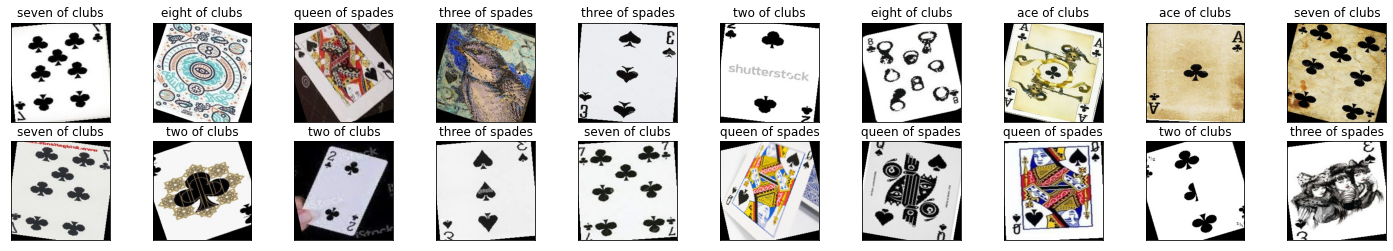

In [16]:
def imshow(img):
    img = img / 2 + 0.5  # Desnormalización.
    plt.imshow(np.transpose(img, (1, 2, 0)))  # Se convierte de tensor a imagen

dataiter = iter(train_loader)
images, labels = dataiter.next()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### Arquitectura de la red 

Se define una arquitectura de red neuronal con 6 capas convolucionales, seguidas por capas de Max Pooling y de una arquitectura Fully Connected seguida de Dropout con un porcentaje del 20 % de desactivación aleatoria de las neuronas. El resumen de la arquitectura definida se puede observar en secciones posteriores.

In [17]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # prof, 224, 224
        self.conv_in = nn.Conv2d(3, 16, 3, padding = 1) # prof, 112, 112
        self.conv1 = nn.Conv2d(16, 32, 3, padding = 1) # prof, 56, 56
        self.conv2 = nn.Conv2d(32, 64, 3, padding = 1) # prof, 28, 28
        self.conv3 = nn.Conv2d(64, 128, 3, padding = 1) # prof, 14, 14
        self.conv4 = nn.Conv2d(128, 256, 3, padding = 1) # prof, 7, 7
        self.pool = nn.MaxPool2d(2, 2) 
        self.fc1 = nn.Linear(256 * 7 * 7, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc_out = nn.Linear(256, 6)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv_in(x))) 
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x))) 
        x = self.pool(F.relu(self.conv3(x))) 
        x = self.pool(F.relu(self.conv4(x))) 
        x = x.view(-1, 256 * 7 * 7)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc_out(x)
        return x

model = Net()
print(model)

# Se mueve el modelo a GPU si está disponible:
if train_on_gpu:
    model.cuda()

# Resumen de la arquitectura definida:
print('Resumen de la arquitectura definida:')
summary(model, input_size=(3, 224, 224))

Net(
  (conv_in): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=256, bias=True)
  (fc_out): Linear(in_features=256, out_features=6, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
         MaxPool2d-2         [-1, 16, 112, 112]               0
            Conv2d-3         [

#### Definicón de la función de costo y del optimizador

Como función de costo de configura la función 'CrossEntropyLoss' y se elige el optimizador de Adam al ser uno de los más eficientes, con una tasa de aprendizaje fijada en 1e-3.

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)